# Part 1

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from zipfile import ZipFile

In [4]:
root_path = '/content/drive/My Drive/RCNN/'
images_zip_path = os.path.join(root_path, 'Images.zip')
airplane_annotations_zip_path = os.path.join(root_path, 'Airplanes_Annotations.zip')

In [12]:
# Check if the zip file exists
if os.path.exists(images_zip_path):
    # Define the directory where you want to extract the files
    extract_dir = root_path  # You can change this if you want to extract to a different directory

    # Open the zip file
    with ZipFile(images_zip_path, 'r') as zip_ref:
        # Extract all the contents into the specified directory
        zip_ref.extractall(extract_dir)

    print("Extraction complete.")
else:
    print("Zip file not found at the specified path:", zip_file_path)

Extraction complete.


In [14]:
# Check if the zip file exists
if os.path.exists(airplane_annotations_zip_path):
    # Define the directory where you want to extract the files
    extract_dir = root_path + 'airplane_annotations/'  # You can change this if you want to extract to a different directory

    # Open the zip file
    with ZipFile(airplane_annotations_zip_path, 'r') as zip_ref:
        # Extract all the contents into the specified directory
        zip_ref.extractall(extract_dir)

    print("Extraction complete.")
else:
    print("Zip file not found at the specified path:", airplane_annotations_zip_path)

Extraction complete.


In [6]:
path = root_path + "Images"
annot = root_path + "Airplanes_Annotations"

airplane_095.jpg


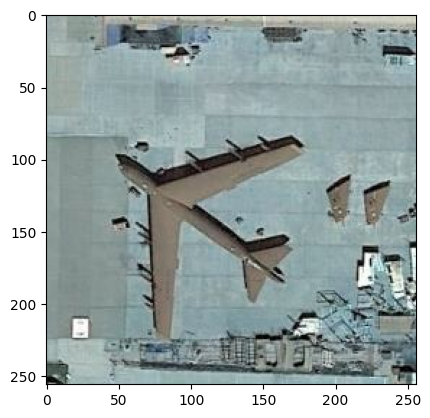

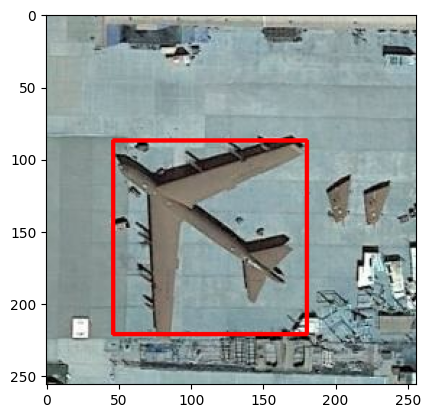

In [7]:
# Display images with bounding boxes from annotation files

for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)

        break

In [8]:
# Enable optimized mode in OpenCV and create a Selective Search segmentation object

cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

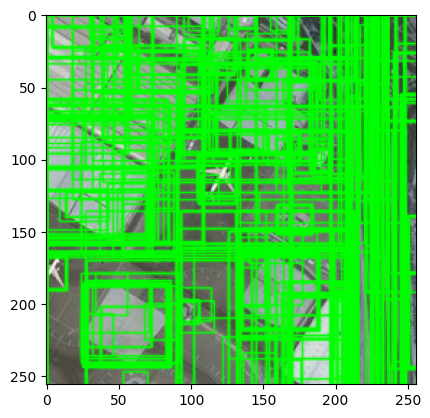

In [9]:
# Read an image and perform Selective Search for object detection

im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    # print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [10]:
train_images=[]
train_labels=[]

In [11]:
# Calculate Intersection over Union (IoU) between two bounding boxes

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [12]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [13]:
# Iterate over annotated images and perform object detection

# 1. Loop through each file (`i`) in the annotated directory (`annot`).
# 2. Check if the filename starts with "airplane".
# 3. Read the corresponding image file (`filename`) and annotation file (`i`) using OpenCV (`cv2`) and pandas (`pd`), respectively.
# 4. Extract ground truth bounding box coordinates (`x1`, `y1`, `x2`, `y2`) from the annotation file and store them in a list (`gtvalues`).
# 5. Set the base image for Selective Search segmentation to the current image.
# 6. Switch to Selective Search Fast mode.
# 7. Process the image with Selective Search and obtain a list of region proposals (`ssresults`).
# 8. Create a copy of the original image (`imout`) for drawing rectangles around detected regions.
# 9. Initialize counters and flags for positive (`counter`), false positive (`falsecounter`), and flags (`flag`, `fflag`, `bflag`) for controlling the loop.
# 10. Iterate over the region proposals (`result`) with a limit of 2000 and until `flag` becomes 1.
# 11. For each region proposal, calculate Intersection over Union (IoU) with each ground truth bounding box.
# 12. If IoU is greater than 0.70 and the positive counter is less than 30, extract the region, resize it to (224,224), and append it to the training data along with the label 1 (positive).
# 13. If IoU is less than 0.3 and the false positive counter is less than 30, extract the region, resize it to (224,224), and append it to the training data along with the label 0 (negative).
# 14. If either the positive or false positive counter reaches 30, set the corresponding flag to 1 to break the loop.
# 15. If both flags (`fflag` and `bflag`) are 1, set the main flag (`flag`) to 1 to break the outer loop.
# 16. Handle exceptions and continue to the next iteration if any error occurs.

for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_095.jpg
1 airplane_094.jpg
2 airplane_093.jpg
3 airplane_092.jpg
4 airplane_091.jpg
5 airplane_090.jpg
6 airplane_089.jpg
7 airplane_088.jpg
8 airplane_087.jpg
9 airplane_086.jpg
10 airplane_085.jpg
inside
11 airplane_084.jpg
12 airplane_083.jpg
inside
13 airplane_082.jpg
14 airplane_081.jpg
15 airplane_080.jpg
16 airplane_079.jpg
17 airplane_078.jpg
18 airplane_077.jpg
19 airplane_076.jpg
20 airplane_075.jpg
inside
21 airplane_074.jpg
22 airplane_073.jpg
23 airplane_072.jpg
24 airplane_070.jpg
25 airplane_067.jpg
26 airplane_065.jpg
27 airplane_062.jpg
inside
28 airplane_059.jpg
29 airplane_057.jpg
30 airplane_054.jpg
31 airplane_051.jpg
32 airplane_049.jpg
33 airplane_046.jpg
34 airplane_043.jpg
35 airplane_041.jpg
inside
36 airplane_038.jpg
37 airplane_035.jpg
38 airplane_033.jpg
39 airplane_030.jpg
40 airplane_027.jpg
41 airplane_025.jpg
42 airplane_022.jpg
43 airplane_019.jpg
44 airplane_017.jpg
45 airplane_014.jpg
46 airplane_011.jpg
47 airplane_009.jpg
48 airplane_006

In [14]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [18]:
X_new.shape

(30229, 224, 224, 3)

In [15]:
# Save X_new to a .npy file
np.save(os.path.join(root_path, 'X_new.npy'), X_new)

# Save y_new to a .npy file
np.save(os.path.join(root_path, 'y_new.npy'), y_new)

# Part 2

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from zipfile import ZipFile
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

root_path = '/content/drive/My Drive/RCNN/'
images_zip_path = os.path.join(root_path, 'Images.zip')
airplane_annotations_zip_path = os.path.join(root_path, 'Airplanes_Annotations.zip')

# Load X_new from the .npy file
X_new = np.load(os.path.join(root_path, 'X_new.npy'))

# Load y_new from the .npy file
y_new = np.load(os.path.join(root_path, 'y_new.npy'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [3]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [5]:
X= vggmodel.layers[-2].output

In [6]:
predictions = Dense(2, activation="softmax")(X)

In [7]:
model_final = Model(inputs = vggmodel.input, outputs = predictions)

In [8]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

In [9]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [10]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [12]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [13]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [14]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [15]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [16]:
# trdata = ImageDataGenerator(horizontal_flip=True, rotation_range=90)
# traindata = trdata.flow(x=X_train, y=y_train)
# tsdata = ImageDataGenerator(horizontal_flip=True, rotation_range=90)
# testdata = tsdata.flow(x=X_test, y=y_test)
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

def data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        for i in range(0, num_samples, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            yield X_batch, y_batch

# Assuming batch_size is defined somewhere in your code
batch_size = 32

train_generator = data_generator(X_train, y_train, batch_size)
test_generator = data_generator(X_test, y_test, batch_size)

hist = model_final.fit_generator(generator=train_generator, steps_per_epoch=5, epochs=10, validation_data=test_generator, validation_steps=2, callbacks=[checkpoint, early])


<ipython-input-16-46466a4cec1d>:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator=train_generator, steps_per_epoch=5, epochs=10, validation_data=test_generator, validation_steps=2, callbacks=[checkpoint, early])


Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 1.1198 - accuracy: 0.7750
Epoch 1: val_loss improved from inf to 0.35490, saving model to ieeercnn_vgg16_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 160s 37s/step - loss: 1.1198 - accuracy: 0.7750 - val_loss: 0.3549 - val_accuracy: 0.8281
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.8313
Epoch 2: val_loss did not improve from 0.35490
5/5 [==============================] - 2s 273ms/step - loss: 0.4947 - accuracy: 0.8313 - val_loss: 0.3557 - val_accuracy: 0.8594
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.7688
Epoch 3: val_loss did not improve from 0.35490
5/5 [==============================] - 1s 223ms/step - loss: 0.5237 - accuracy: 0.7688 - val_loss: 0.8366 - val_accuracy: 0.6875
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8500
Epoch 4: val_loss did not improve from 0.35490
5/5 [==============================] - 1s 239ms/step - loss: 0.4249 - accuracy: 0.8500 - val_loss: 0.4984 - val_accuracy: 0.7812
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0

In [18]:
# Assuming model_final is your trained model
model_final.save(root_path + "ieeercnn_vgg16_1_trained.h5")

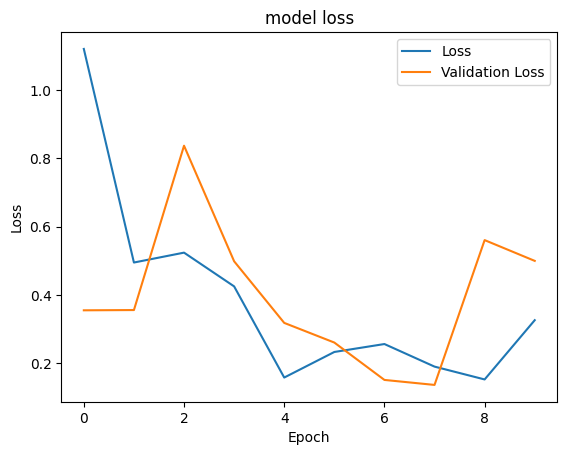

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 [==============================] - 0s 30ms/step
plane


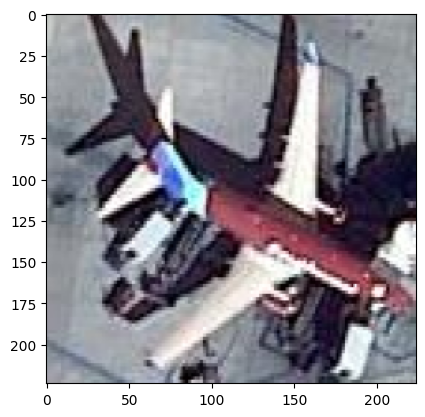

In [20]:
im = X_test[16]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

1/1 [==============================] - 0s 20ms/step


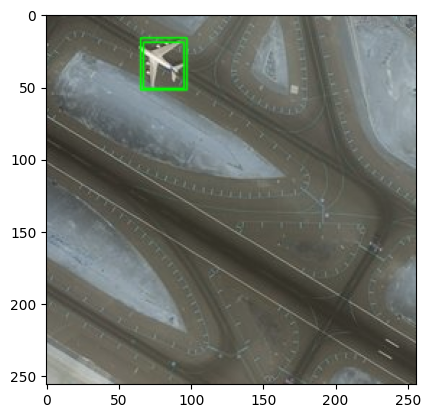

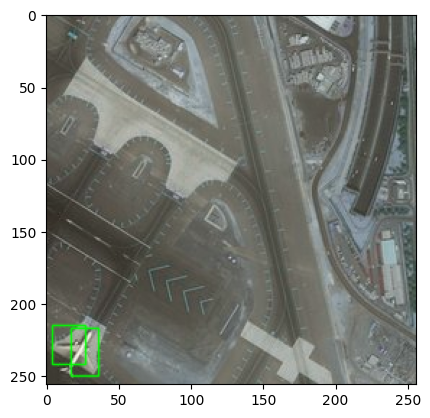

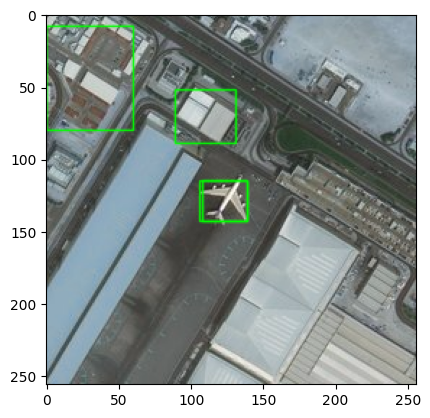

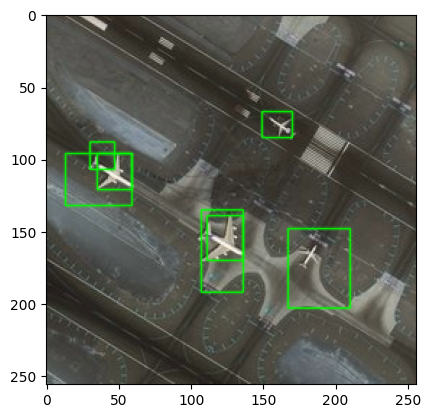

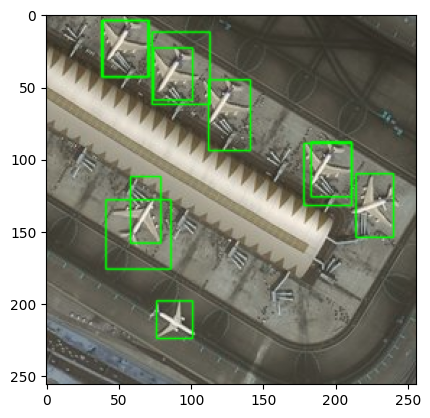

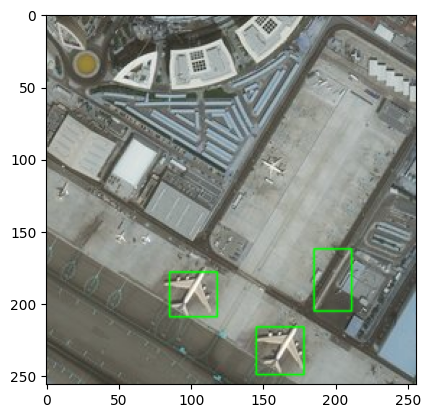

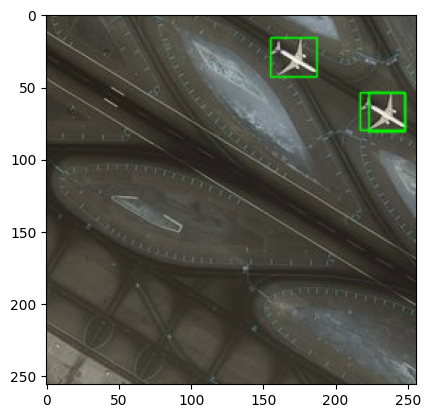

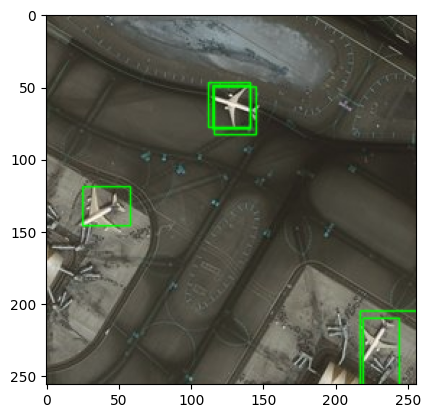

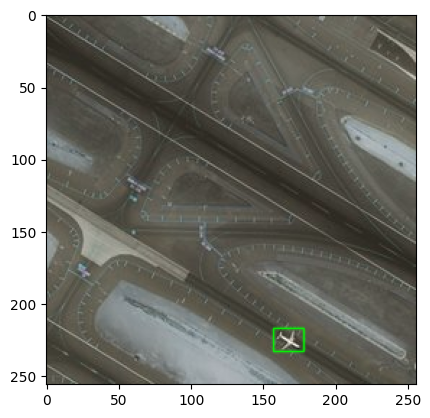

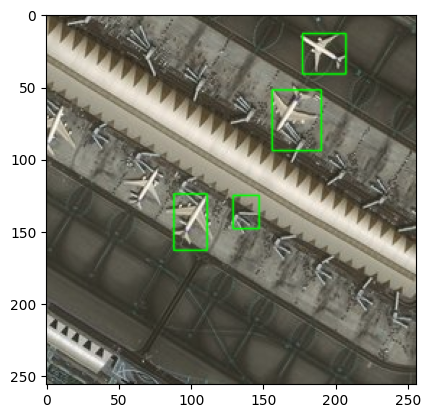

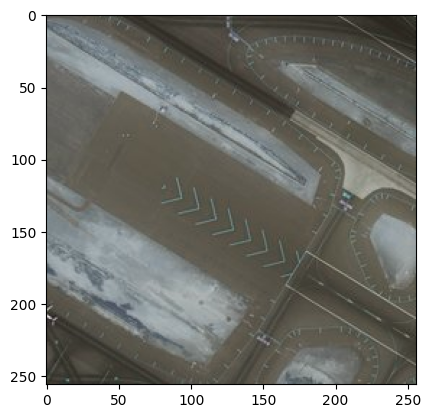

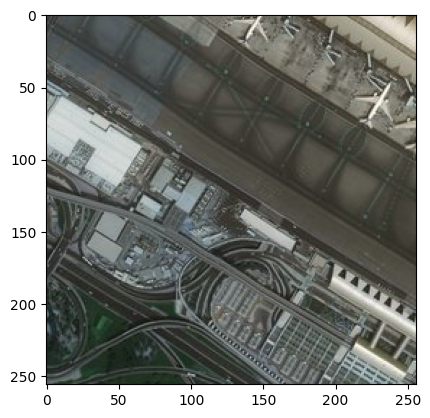

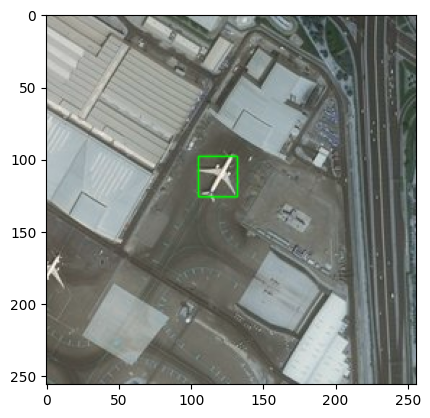

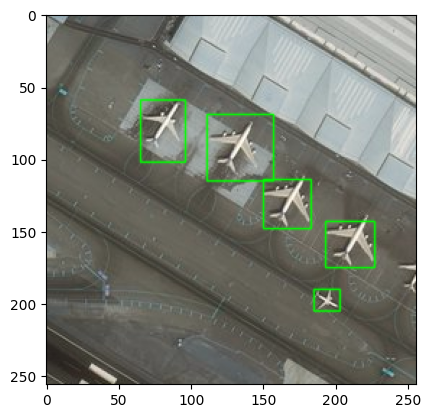

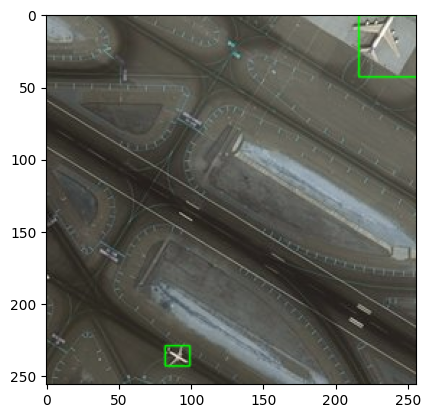

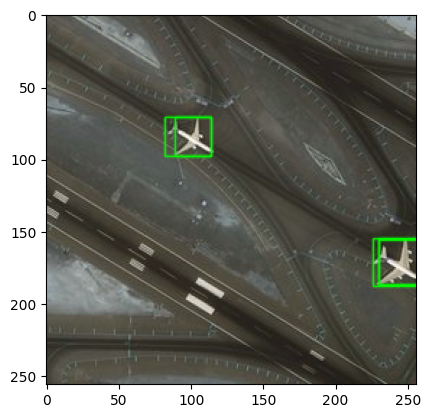

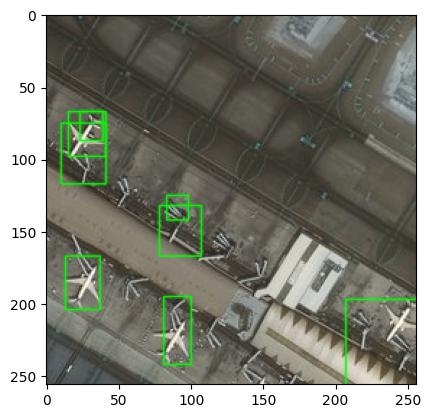

In [23]:
z=0
path = root_path + "Images"
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)